# FUSOR Demonstrative Analysis
This notebook contains a demonstrative analysis of the FUSOR package, showing how fusion events detected from patient samples at Nationwide Children's Hospital's Institute for Genomic Medicine (IGM) can be matched to the CIViC and Molecular Oncology Almanac (MOA) databases.

The cells below are run to set environment variables and load in FUSOR.

In [1]:
from os import environ
import logging
from pathlib import Path
from tqdm import tqdm

# These are the configurations for the UTA and SeqRepo databases. These should
# be adjusted by the user based on the locations where these databases exist.
environ["UTA_DB_URL"] = "postgresql://anonymous@localhost:5432/uta/uta_20241220"
environ["SEQREPO_ROOT_DIR"] = "/usr/local/share/seqrepo/2024-12-20"

# Cool-Seq-Tool will log warning messages for reasons including having breakpoints
# that occur outside of the transcript boundaries and having gene partners 
# that do not have MANE select transcripts. We are silencing these warning 
# messages in the output, as FUSOR objects can still be generated for these
# cases.
logging.getLogger("cool_seq_tool").setLevel(logging.ERROR)

In [2]:
from fusor.fusor import FUSOR

fusor = FUSOR()

***Using Gene Database Endpoint: http://localhost:8000***


## Prepare and Load `CategoricalFusion` Data

### CIViC

The cell below loads from the saved CIViC cache (from 9/22/25) and creates a list of `CategoricalFusion` objects. We are filtering for `accepted` and `submitted` variants from CIViC. 

In [3]:
from fusor.harvester import CIVICHarvester

harvester = CIVICHarvester(fusor=fusor, local_cache_path="data/caches/civic_cache_20250922.pkl", include_status=["accepted", "submitted"])
civic_fusions = await harvester.load_records()

ERROR:fusor.harvester:Cannot translate fusion: FGFR3(entrez:2261)::v due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 412, in load_records
    cat_fusion = await self.translator.translate(civic=fusion)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/translator.py", line 993, in translate
    raise ValueError(msg)
ValueError: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
ERROR:fusor.harvester:Cannot translate fusion: TCF3(entrez:6929)::PBX1(entrez:5087) due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 412, in load_records
    cat_fusion

There are 5 fusions from CIViC that fail to translate:
- 1 fusion fails to translate as the 3' partner is said to be SSX4 in CIViC when it is likely SSX4B
- 4 fusions fail to translate as they are missing genomic coordinates in CIViC, which is required for fusions described using GRCh37 transcripts

### MOA

The cell below loads from the saved MOA cache (9/4/25) and creates a list of `CategoricalFusion` objects.

In [4]:
from fusor.harvester import MOAHarvester

harvester = MOAHarvester(fusor=fusor, cache_dir=Path("data/caches"), use_local=True)
moa_fusions = harvester.load_records()

## Translate `AssayedFusion` objects from EnFusion files

The cell below can be run to generate a list of translated `AssayedFusion` objects from a subset of EnFusion output from 17 patient samples at IGM. This cell takes around 5.5 minutes to run. The fusion events were detected at a sequencing depth of 200 million reads, and were returned if they were detected by three or more of the following fusion callers: FusionMap, FusionCatcher, JAFFA, STAR-Fusion, CICERO, Arriba.

In [5]:
from fusor.harvester import EnFusionHarvester
from cool_seq_tool.schemas import Assembly

harvester = EnFusionHarvester(fusor=fusor, assembly=Assembly.GRCH38)
assayed_fusions_enfusion = []
patient_ids = []
files = [patient_file.name for patient_file in Path("data/fusion-test-data").iterdir() if patient_file.is_file() and patient_file.suffix == ".tsv"]

for file in tqdm(files):
    fusions = await harvester.load_records(fusion_path=Path(f"data/fusion-test-data/{file}"))
    for fusion in fusions:
        patient_ids.append(file)
    assayed_fusions_enfusion.extend(fusions)

100%|██████████| 17/17 [06:12<00:00, 21.91s/it]


## 1. Use `FusionMatcher` to match patient fusions against CIViC and MOA

The cell below can be run to use the `FusionMatcher` module to match the translated EnFusion output, containting patient fusion data, against CIViC and MOA. Matches are prioritized and returned according to predefined [match criteria](https://github.com/cancervariants/fusor/wiki/Fusion-Match-Classes).

In [6]:
from fusor.fusion_matching import FusionMatcher

fm = FusionMatcher(assayed_fusions=assayed_fusions_enfusion,
                   comparator_fusions=civic_fusions + moa_fusions)

matches = await fm.match_fusion()

### Create Patient Variant Dictionary
The cell below can be run to create a dictionary containing the returned matching `CategoricalFusion` objects for each patient sample.

In [7]:
from collections import defaultdict

matches_ids = []
for match, id in zip(matches, patient_ids):
    if match:
        matches_ids.append((match, id))

patient_match_dict = defaultdict(list)

for tup in matches_ids:
    obj, pid = tup
    patient_match_dict[pid].append(tup[0])
patient_match_dict = dict(patient_match_dict)

## 2. Fusion Match Characterization
The cells below analyze the results of the matching analysis, describing the types of `CategoricalFusions` matches that are returned given an `AssayedFusion` query and the types of evidence that are associated with those matches.

The helper functions below are used throughout this section:

In [8]:
from fusor.models import CategoricalFusion
from fusor.fusion_matching import MatchType
from collections import Counter

def count_match_types(matches: list[tuple[CategoricalFusion, MatchType]]) -> dict:
    """Count the number of match types across a list of matching output
    
    :param matches: A list of tuples containing CategoricalFusion and MatchType 
        objects
    :return: A dictionary describing the number of fusions that belong in each 
        shared fusion match category"""
    element_counts = [match[1].priority // 10 for match in matches]
    element_counts = Counter(element_counts)
    map = {1: "exact", 2:"shared_genes_exact_one_partner", 3:"shared_genes", 
           4:"exact_one_partner", 5:"shared_gene_one_partner"}
    return {map[key]: value for key, value in element_counts.items()}

In [9]:
def count_match_types_patient(match_info: list[list[tuple[CategoricalFusion, MatchType]]]) -> dict[str, int]:
    """Count the number of match types that occur across a patient sample
    
    :param match_info: A list of list of tuples containing the match information
        for a patient sample
    :return: A dictionary describing match information at the patient level
    """
    categories = [
        "exact",
        "shared_genes_exact_one_partner",
        "shared_genes",
        "exact_one_partner",
        "shared_gene_one_partner",
    ]
    total_counts = Counter({cat: 0 for cat in categories})
    
    for match in match_info:
        match_dat = count_match_types(match)
        total_counts.update({k: match_dat.get(k, 0) for k in categories})
    
    return dict(total_counts)

### Get highest returned priority match type across patients
The cell below reports the highest priority type that is returned for the matching `CategoricalFusions` for each patient sample.

In [10]:
highest_priority = []
for patient in patient_match_dict:
    priority = count_match_types_patient(patient_match_dict[patient])
    for key in priority:
        if priority[key] > 0:
            highest_priority.append(key)
            break
highest_priority

['shared_genes',
 'exact',
 'shared_genes',
 'shared_genes_exact_one_partner',
 'exact',
 'shared_genes_exact_one_partner',
 'exact',
 'exact',
 'shared_genes',
 'exact',
 'shared_genes',
 'exact_one_partner',
 'shared_genes_exact_one_partner',
 'shared_genes',
 'shared_genes_exact_one_partner',
 'exact']

Run the cells below to visualize the highest fusion priority type that is returned for each patient sample.

In [11]:
import pandas as pd

match_counts = Counter(highest_priority)

columns = ["priority_type", "count"]
highest_priority_df = pd.DataFrame(columns=columns)
highest_priority_df["priority_type"] = ["exact", "shared_genes_exact_one_partner",
                                        "shared_genes",  "exact_one_partner",]
highest_priority_df["count"] = [match_counts["exact"], 
                                match_counts["shared_genes_exact_one_partner"],
                                match_counts["shared_genes"],
                                match_counts["exact_one_partner"]]

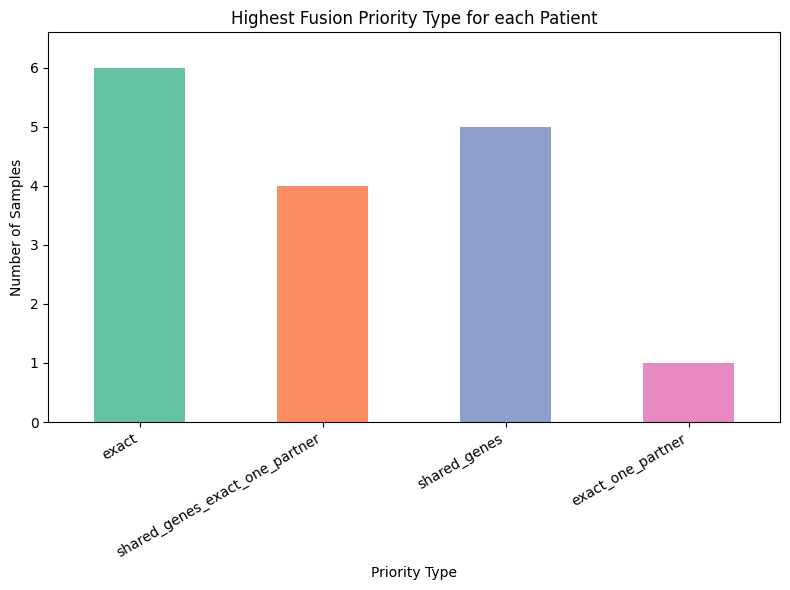

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

bar_colors = sns.color_palette("Set2")

ax = highest_priority_df.plot.bar(x="priority_type", y="count",
                                  title="Highest Fusion Priority Type for each Patient",
                                  figsize=(8, 6), color=bar_colors, legend=False)
plt.xlabel("Priority Type")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30, ha="right")
plt.margins(x=0.05, y=0.1)
plt.tight_layout()  
plt.show()

### Compute Match Type Summary Statistics
Run the cell below to compute summary statistics describing the types of matches that were returned.

In [13]:
print(f"The number of translated fusion across the 17 examined patient files is: {len(assayed_fusions_enfusion)}")
print(f"The number of patient assayed fusions that had at least one match against CIViC and MOA is: {len([match for match in matches if match])}")

# Compute the number of match types across the different patient samples
priority_counts = [count_match_types_patient(patient_match_dict[patient]) for patient in patient_match_dict]
combined_counts = dict(sum((Counter(d) for d in priority_counts), Counter()))
categories = [
    "exact",
    "shared_genes_exact_one_partner",
    "shared_genes",
    "exact_one_partner",
    "shared_gene_one_partner",
]
combined_counts = {cat: combined_counts[cat] for cat in categories}
f"The breakdown of returned match types across the testing set is: {combined_counts}"

The number of translated fusion across the 17 examined patient files is: 2362
The number of patient assayed fusions that had at least one match against CIViC and MOA is: 191


"The breakdown of returned match types across the testing set is: {'exact': 13, 'shared_genes_exact_one_partner': 8, 'shared_genes': 86, 'exact_one_partner': 47, 'shared_gene_one_partner': 638}"

## 3. Clinical Evidence Comparison


The cells below are used to extract the levels of evidence (e.g. A-E) that are returned for matching `CategoricalFusion` objects from the CIViC knowledgebase.

The helper functions below are used throughout this section:

In [14]:
from civicpy.civic import MolecularProfile
from fusor.models import CategoricalFusion

def get_evidence_ratings_per_mp(mp: MolecularProfile) -> dict:
    """Get a dictionary describing evidence ratings associated with a
    MolecularProfile object

    :param mp: A MolecularProfile object
    :return: A dictionary containing the number of evidence items with a given
        rating (A-E)
    """
    ratings = [e.evidence_level for e in mp.evidence_items]
    return dict(Counter(ratings))

def aggregate_evidence_ratings(dicts: list[dict]) -> dict:
    """Helper function used to aggreate evidence rating counts
    
    :param dicts: A list of dictionaries
    :return: A dictionary with the aggregate count across the list
    """
    counter = Counter()
    for r_dict in dicts:
        counter.update(r_dict)
    counter = {k: counter.get(k, 0) for k in ["A", "B", "C", "D", "E"]}
    return dict(counter)

def aggregate_evidence_ratings_per_fusion(fusion: CategoricalFusion) -> dict:
    """Get a dictionary containing the number of times a given evidence rating
    appears across a list of MolecularProfiles associated with a fusion

    :param fusion: A CategoricalFusion object
    :return: A dictinonary describing the evidence rating counts across the
        fusion
    """
    r_dicts = [get_evidence_ratings_per_mp(mp) for mp in fusion.extensions[0].value]
    return aggregate_evidence_ratings(r_dicts)

def aggregate_evidence_ratings_per_matching_output(fusions: 
                                                   list[tuple[CategoricalFusion, MatchType]]) -> dict:
    """Count number of times evidence ratings appear across a list of matched
    CategoricalFusion objects. This is only supported for matched fusions
    from CIViC

    :param fusions: A list of tuples CategoricalFusion objects and MatchTypes
    :return: A dictionary describing the evidence rating counts across the
        lists of fusions
    """
    r_dicts = [aggregate_evidence_ratings_per_fusion(fusion[0]) for fusion
               in fusions if fusion[0].extensions[0].name == "civicMolecularProfiles"]
    return aggregate_evidence_ratings(r_dicts)

def aggregate_evidence_ratings_per_sample(matches: list[list[tuple[CategoricalFusion, MatchType]]]) -> dict:
    """Aggregate evidence rating counts at the sample level
    
    :param matches: A list containing lists of tuples of returned matching 
        CategoricalFusion objects and their MatchTypes
    :return: A dictionary containing the aggregate rating counts at the sample
        level
    """
    match_dicts = [aggregate_evidence_ratings_per_matching_output(match) for
                   match in matches]
    return aggregate_evidence_ratings(match_dicts)

### Compute the ratings of returned evidence at the patient level
Run the cell below to generate a list of dictionaries describing the returned evidence ratings for each patient sample. This output is limited to returned fusions from CIViC. It is possible for different `MolecularProfile` objects to share the same evidence IDs, so the counts below represent **aggregate** evidence ratings counts.

In [15]:
[aggregate_evidence_ratings_per_sample(patient_match_dict[sample]) for sample in patient_match_dict]

[{'A': 3, 'B': 17, 'C': 4, 'D': 2, 'E': 0},
 {'A': 0, 'B': 8, 'C': 0, 'D': 1, 'E': 0},
 {'A': 0, 'B': 0, 'C': 2, 'D': 0, 'E': 0},
 {'A': 5, 'B': 3, 'C': 23, 'D': 3, 'E': 0},
 {'A': 80, 'B': 127, 'C': 388, 'D': 226, 'E': 16},
 {'A': 2, 'B': 10, 'C': 12, 'D': 14, 'E': 0},
 {'A': 2, 'B': 7, 'C': 12, 'D': 14, 'E': 0},
 {'A': 63, 'B': 203, 'C': 570, 'D': 294, 'E': 0},
 {'A': 0, 'B': 17, 'C': 9, 'D': 1, 'E': 0},
 {'A': 2, 'B': 7, 'C': 13, 'D': 14, 'E': 0},
 {'A': 0, 'B': 4, 'C': 1, 'D': 3, 'E': 0},
 {'A': 0, 'B': 21, 'C': 7, 'D': 7, 'E': 0},
 {'A': 1, 'B': 18, 'C': 10, 'D': 1, 'E': 0},
 {'A': 1, 'B': 5, 'C': 3, 'D': 2, 'E': 0},
 {'A': 19, 'B': 50, 'C': 255, 'D': 231, 'E': 0},
 {'A': 32, 'B': 161, 'C': 462, 'D': 277, 'E': 0}]